# How does the fringe transmission change on the sides of the PSF peak?
In notebook 4 we examined how the fringe transmission of a point source changes for different across and along-slice positions on the detector. The exercise involved solely the peak intensity of the point sources. Here we check that the conclusions drawn apply for the different PSF locations. Remember that this test was done in notebook 2 for the point source etalon data and no variation in the position of the etalon lines was found. This fact is used as a visual guideline in the simulations that follow.

## > Import modules

In [1]:
import funcs
import mrsobs

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

## > Get data
We load the images for one band of the MRS for different kinds of sources, including: 
* MTS 800K BB extended source observed through etalon "ET1A"
* MTS 800K BB extended source observed through 100micron pinhole 
  
Additionally the pixel-to-wavelength calibration map and the pixel-to-along-slice position map are imported.

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band = '1A'
ext_etal_source_sci,ext_etal_source_bkg     = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A')
point_source_sci_p1,point_source_bkg_p1 = mrsobs.FM_MTS_800K_BB_point_source_raster(lvl2path,position='middle',pointing='P1')

# Get wavelength calibration pixel map
d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
lambdaMap = d2cMaps['lambdaMap']
lambdaMap[lambdaMap==0] = np.nan
alphaMap = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']

## > Transform data
We subtract background exposures where available

In [3]:
# perform transform
ext_etal_source_bkgsubtr   = ext_etal_source_sci-ext_etal_source_bkg
point_source_p1_bkgsubtr = point_source_sci_p1-point_source_bkg_p1

We perform an even-odd row signal correction to the data (caused by the read-out pattern of MIRI detector pixel rows)

In [4]:
ext_etal_source_oddevencorr = funcs.OddEvenRowSignalCorrection(ext_etal_source_bkgsubtr)
point_source_p1_oddevencorr = funcs.OddEvenRowSignalCorrection(point_source_p1_bkgsubtr)

## > Modeling
Much like in notebook 2 we take the three slices that contain the PSF (slices with largest signal), determine the pixel trace that contains the peak of the PSF, and then take the two traces on the left and the right to probe the sides of the PSF.  
  
Note that the expectation is **not** for the fringe transmission to be the same in different slices. Contrary to the etalon point source data which probed the physical (plane-parallel) etalon, we now probe the detector structure and its inhomogeneities.

In [5]:
# Pixel trace in MRS slice
ypos_sourcecenterslice,xpos_sourcecenterslice = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps,offset_slice=0)
ypos_nearbyslice1,xpos_nearbyslice1 = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps,offset_slice=-1)
ypos_nearbyslice2,xpos_nearbyslice2 = funcs.detpixel_trace_compactsource(point_source_p1_oddevencorr,band,d2cMaps,offset_slice=1)
xpos_offsets = [-2,-1,0,1,2]

Source center slice ID: 7
Source center slice ID: 7
Source center slice ID: 7


### Test 1: Check discrepancies between etalon lines and point source fringes in across-slice direction

In [6]:
# normalize signal
pointsource_norm = {}
pointsource_norm['slice6'] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],thres=0,min_dist=6,k=3,ext=3)
pointsource_norm['slice7'] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],thres=0,min_dist=6,k=3,ext=3)
pointsource_norm['slice8'] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],thres=0,min_dist=6,k=3,ext=3)

<IPython.core.display.Javascript object>


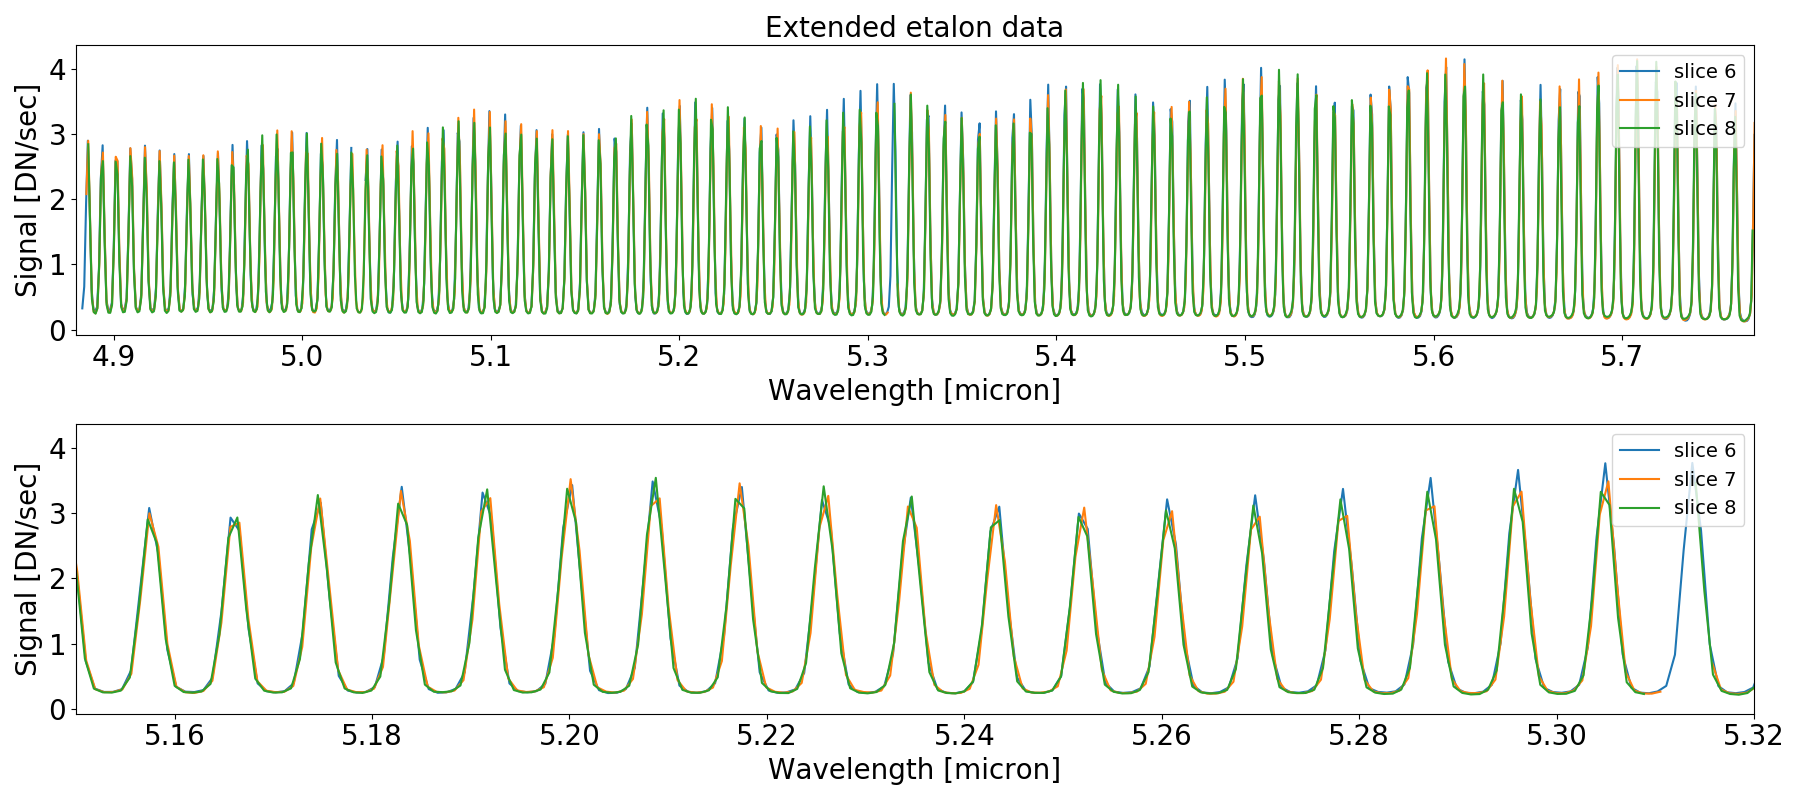

<IPython.core.display.Javascript object>


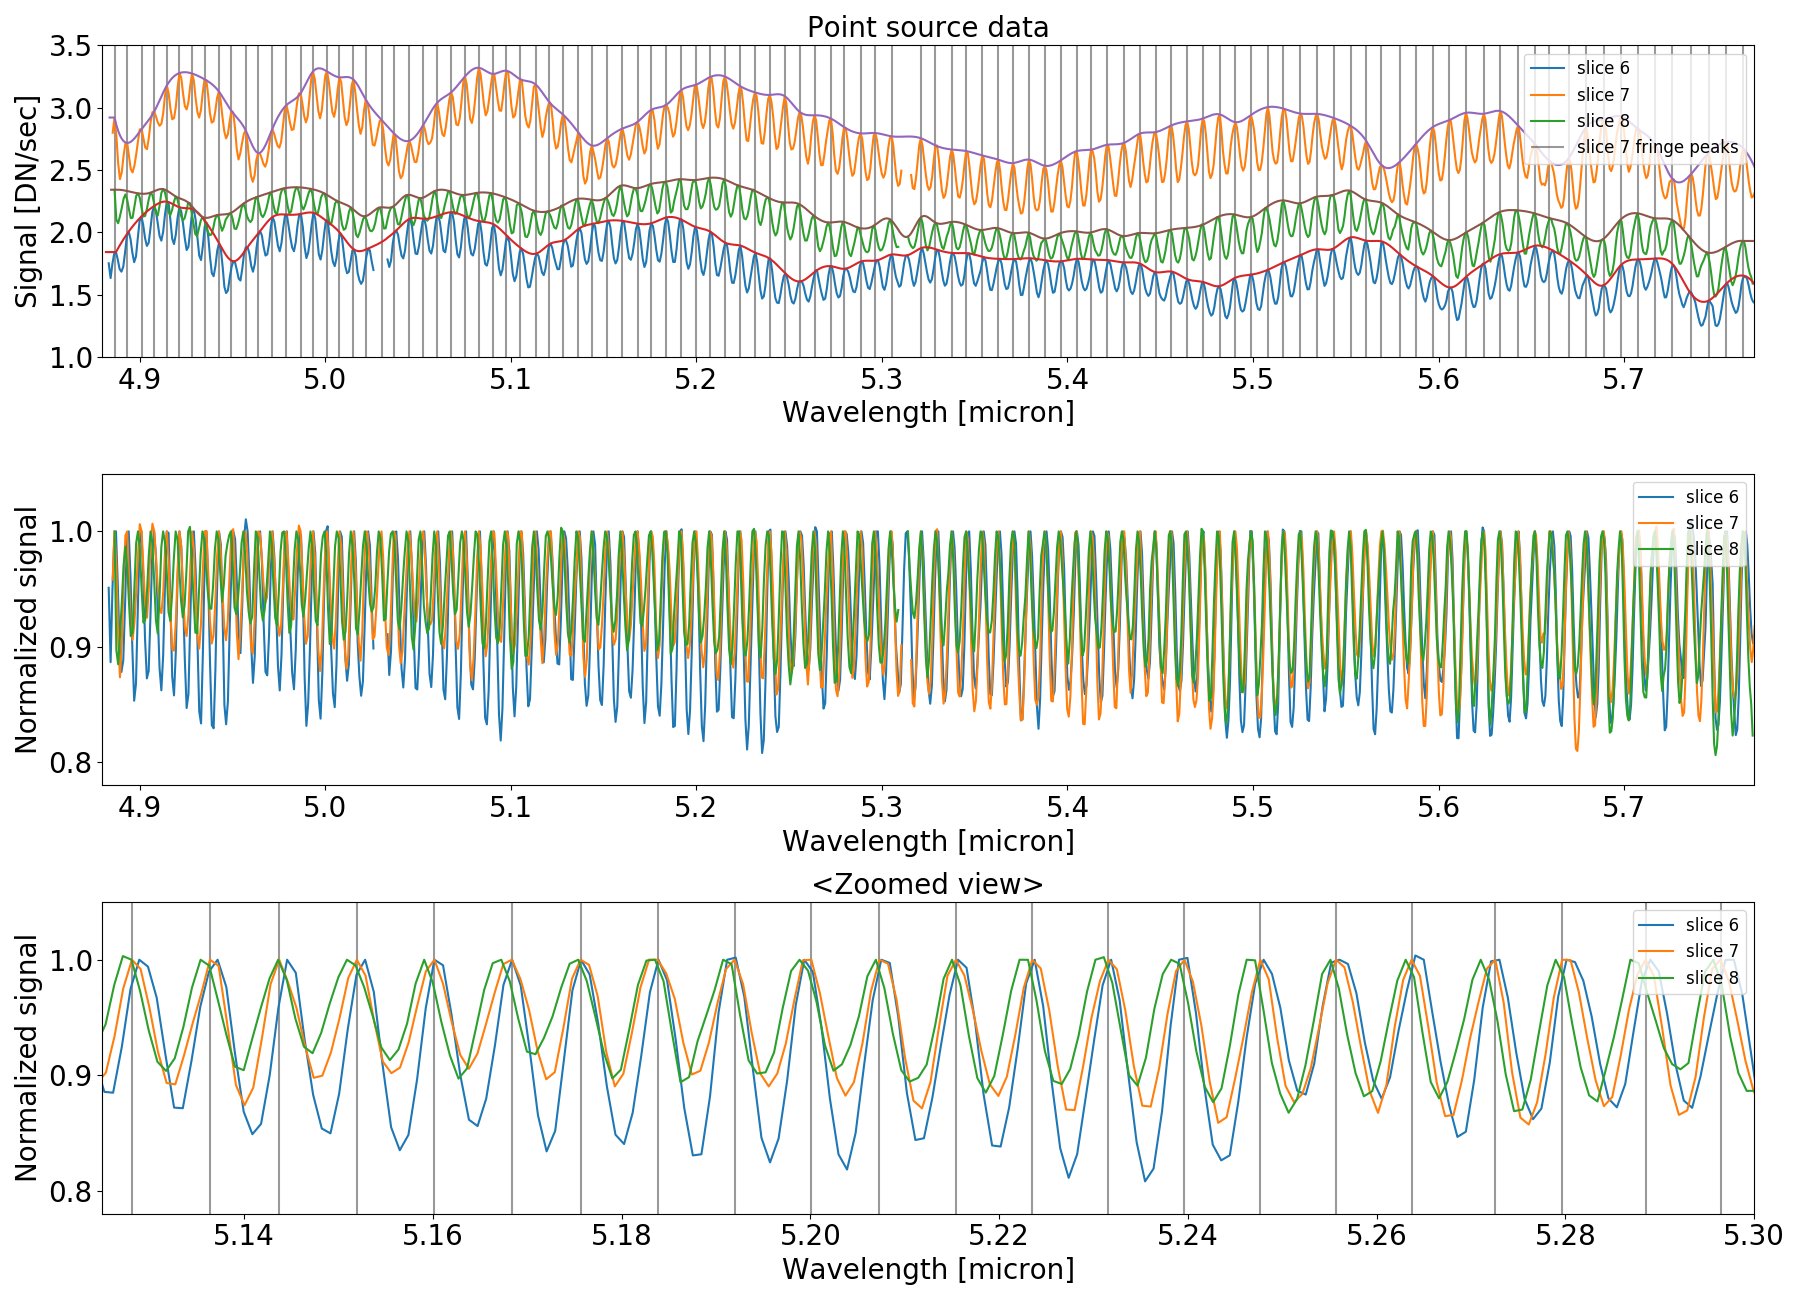

In [7]:
# let's look at the results
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Extended etalon data')
for plot in range(2):
    axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],label='slice 6')
    axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],ext_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],label='slice 7')
    axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],ext_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],label='slice 8')
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Signal [DN/sec]')
    axs[plot].legend(loc='upper right',fontsize=14)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(5.15,5.32)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Point source data')
axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],point_source_p1_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1],label='slice 6')
axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],point_source_p1_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice],label='slice 7')
axs[0].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][pointsource_norm['slice7'][1]],1,3.5,alpha=0.4,label='slice 7 fringe peaks')
axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],point_source_p1_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2],label='slice 8')
axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][:-1],pointsource_norm['slice6'][2][:-1])
axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][:-1],pointsource_norm['slice7'][2][:-1])
axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2][:-1],pointsource_norm['slice8'][2][:-1])
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(1,3.5)
for plot in range(1,3):
    axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1],point_source_p1_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1]/pointsource_norm['slice6'][2],label='slice 6')
    axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice],point_source_p1_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice]/pointsource_norm['slice7'][2],label='slice 7')
    axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2],point_source_p1_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2]/pointsource_norm['slice8'][2],label='slice 8')
    axs[plot].set_ylim(0.78,1.05)
    axs[plot].set_ylabel('Normalized signal')
axs[2].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][pointsource_norm['slice7'][1]],0.78,1.05,alpha=0.4)
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=12)
axs[0].set_xlim(4.88,5.77)
axs[1].set_xlim(4.88,5.77)
axs[2].set_xlim(5.125,5.3)
axs[0].set_ylabel('Signal [DN/sec]')
axs[2].set_title('<Zoomed view>')
plt.tight_layout()

### Remarks:
* The etalon lines in the extended etalon data match in different slices (as shown in previous notebooks).
* The point source fringes have different frequency and amplitude in different slices. Since the etalon lines at the same positions match, we suppose that the change in frequency is not due to inaccurracies in the wavelength calibration.

### Test 2: Check discrepancies between etalon lines and point source fringes in along-slice direction

In [8]:
# normalize signal
pointsource_slice6_norm,pointsource_slice7_norm,pointsource_slice8_norm = [{} for i in range(3)]
for xpos_offset in xpos_offsets:
    pointsource_slice6_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],thres=0,min_dist=6,k=1,ext=3)
    pointsource_slice7_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],thres=0,min_dist=6,k=1,ext=3)
    pointsource_slice8_norm['offset'+str(xpos_offset)] = funcs.norm_fringe(point_source_p1_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],thres=0,min_dist=6,k=1,ext=3)

<IPython.core.display.Javascript object>


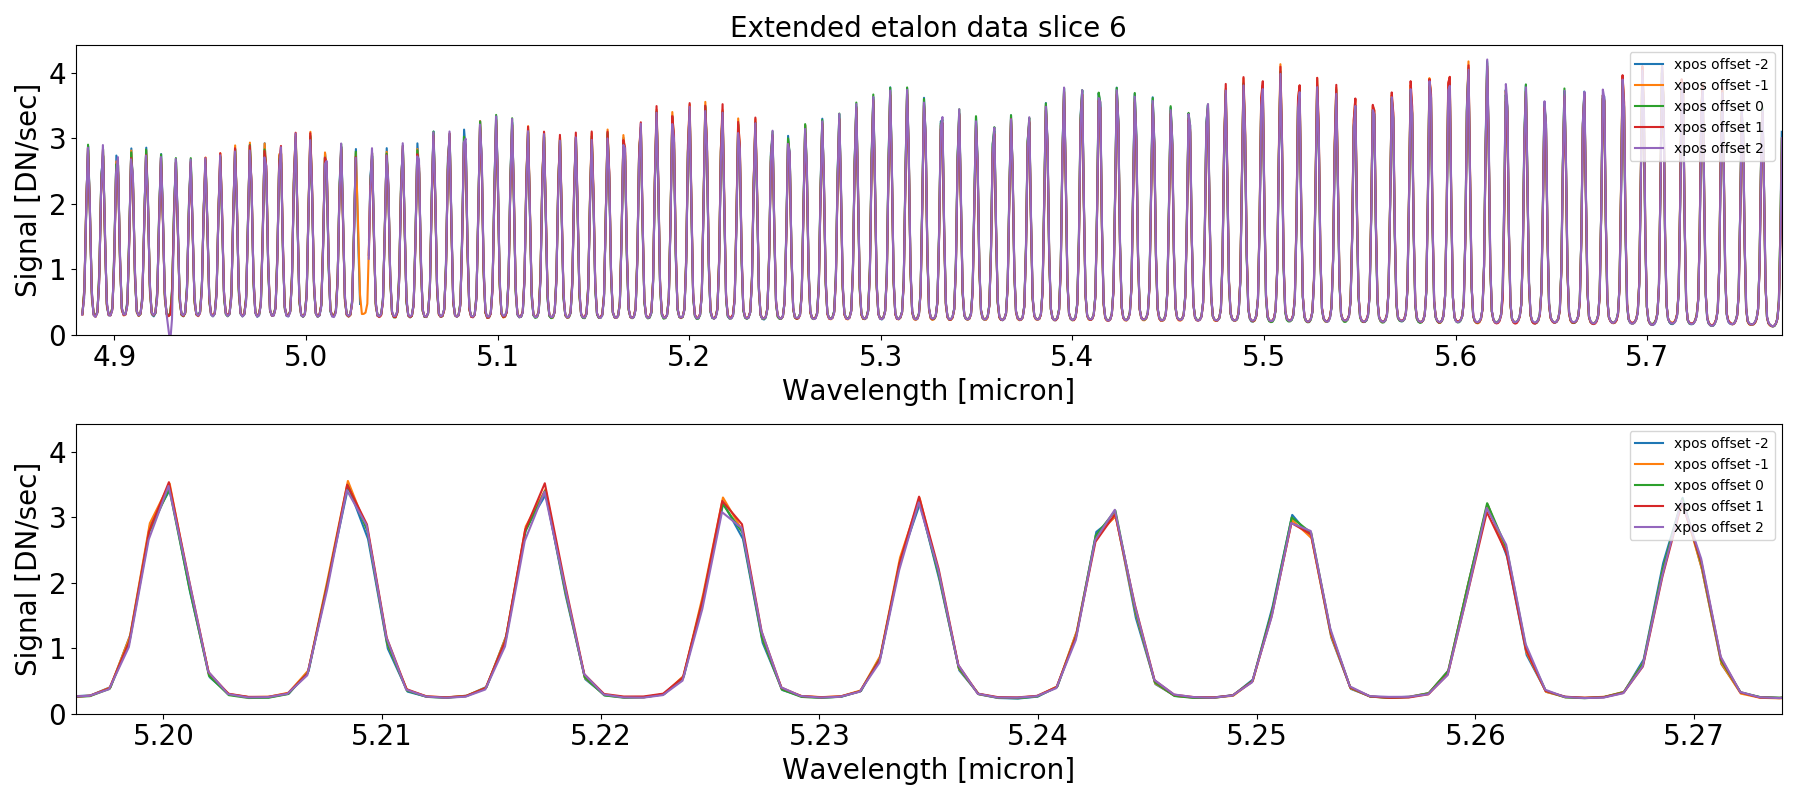

<IPython.core.display.Javascript object>


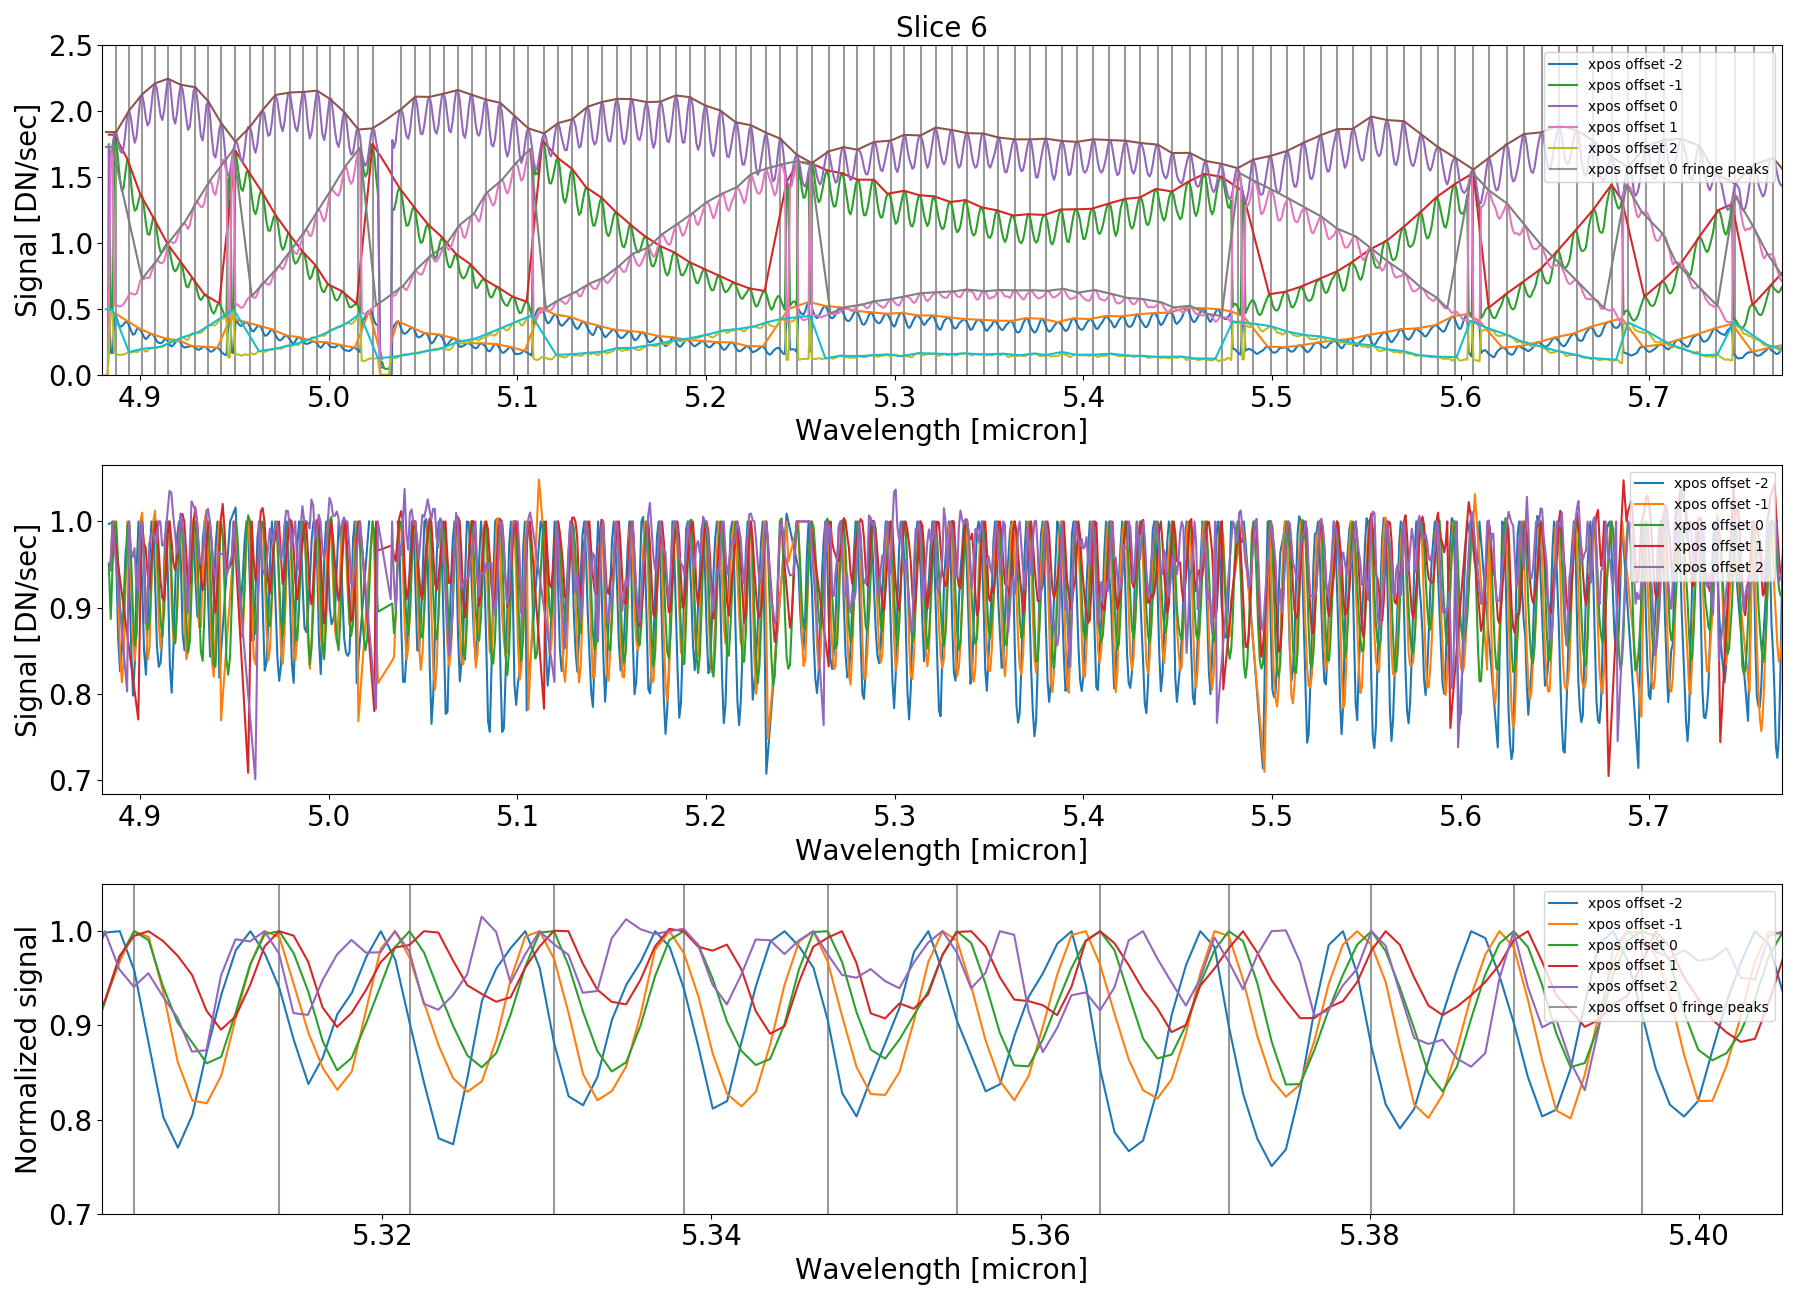

In [9]:
# let's look at the results (slice 6)
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Extended etalon data slice 6')
for xpos_offset in xpos_offsets:
    for plot in range(2):
        axs[plot].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],ext_etal_source_oddevencorr[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],label='xpos offset {}'.format(xpos_offset))
        axs[plot].set_xlabel('Wavelength [micron]')
        axs[plot].set_ylabel('Signal [DN/sec]')
        axs[plot].legend(loc='upper right',fontsize=10)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0)
axs[1].set_xlim(5.196,5.274)
axs[1].set_ylim(0)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Slice 6')
axs[0].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][pointsource_slice6_norm['offset0'][1]],0,2.5,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],pointsource_slice6_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset],pointsource_slice6_norm['offset'+str(xpos_offset)][2])
    norm_transmission = pointsource_slice6_norm['offset'+str(xpos_offset)][0]/pointsource_slice6_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].vlines(lambdaMap[ypos_nearbyslice1,xpos_nearbyslice1][pointsource_slice6_norm['offset0'][1]],0.7,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(0,2.5)
axs[2].set_xlim(5.303,5.405)
axs[2].set_ylim(0.7,1.05)
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_ylabel('Signal [DN/sec]')
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

### Remarks:
* Although the etalon lines match, the fringe phase of the point source differs significantly. What we are seeing is the position of the point source fringes seemingly shift from left to right (this could of course be a false impression of continuity, assuming a wave progressing towards the right, i.e. longer wavelengths). As of yet it is not clear why such a situation occurs, however the effect is non-negligible. We know from Notebook 1 - Test 3 that the extended source fringes do not move over a much larger range of along-slice positions, yet the point source fringe do.
* One should be careful; the fact that the etalon lines don't move does not necessarily translate to the point source fringes not moving. The reason this is made explicit here is because the etalon lines probe the intereference in the etalon in-use, not the detector interference (not directly, but likely through the beating profile, which is tricky to analyze meticulously).
* The amplitude of the fringes changes as a function of location on the PSF. This could be bluntly linked to the "decrease in signal", however the matter of the fact is that the fringe amplitude should **not** be dependent on the absolute level of the signal. The fact that it does change implies a decrease of contrast, that somehow the pixels are more effective at resolving the light at the peak of the PSF than on the sides. That said we also see that that is not true given that the contrast of the (xpos offset -2) fringes is the largest out of all the different positions (xpos offsets).
  
Let's look at the other slices.

<IPython.core.display.Javascript object>


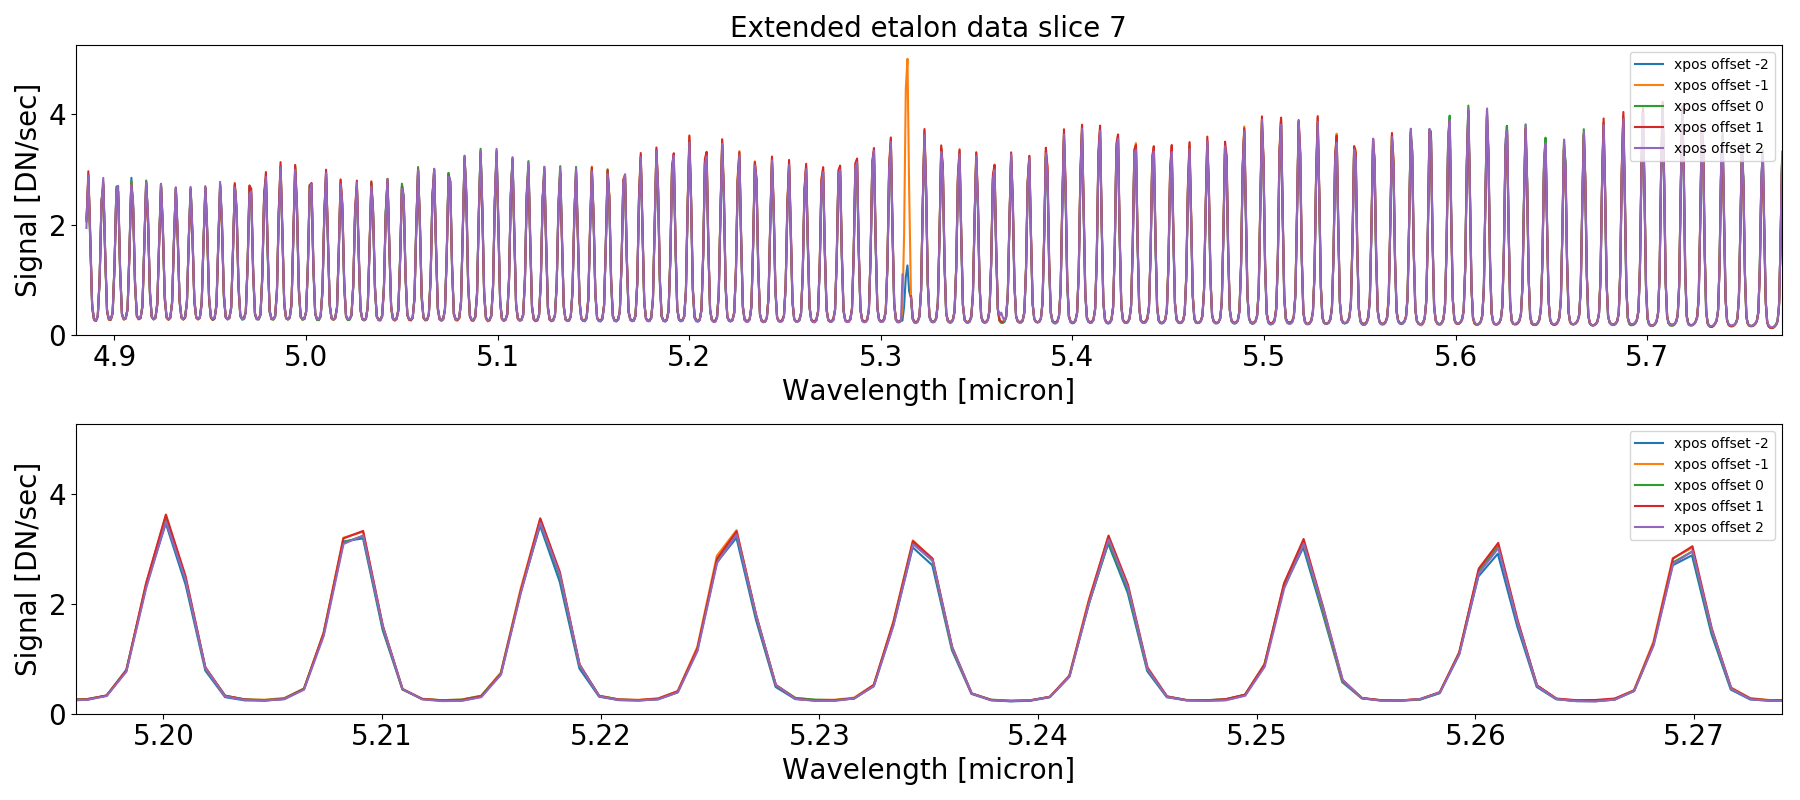

<IPython.core.display.Javascript object>


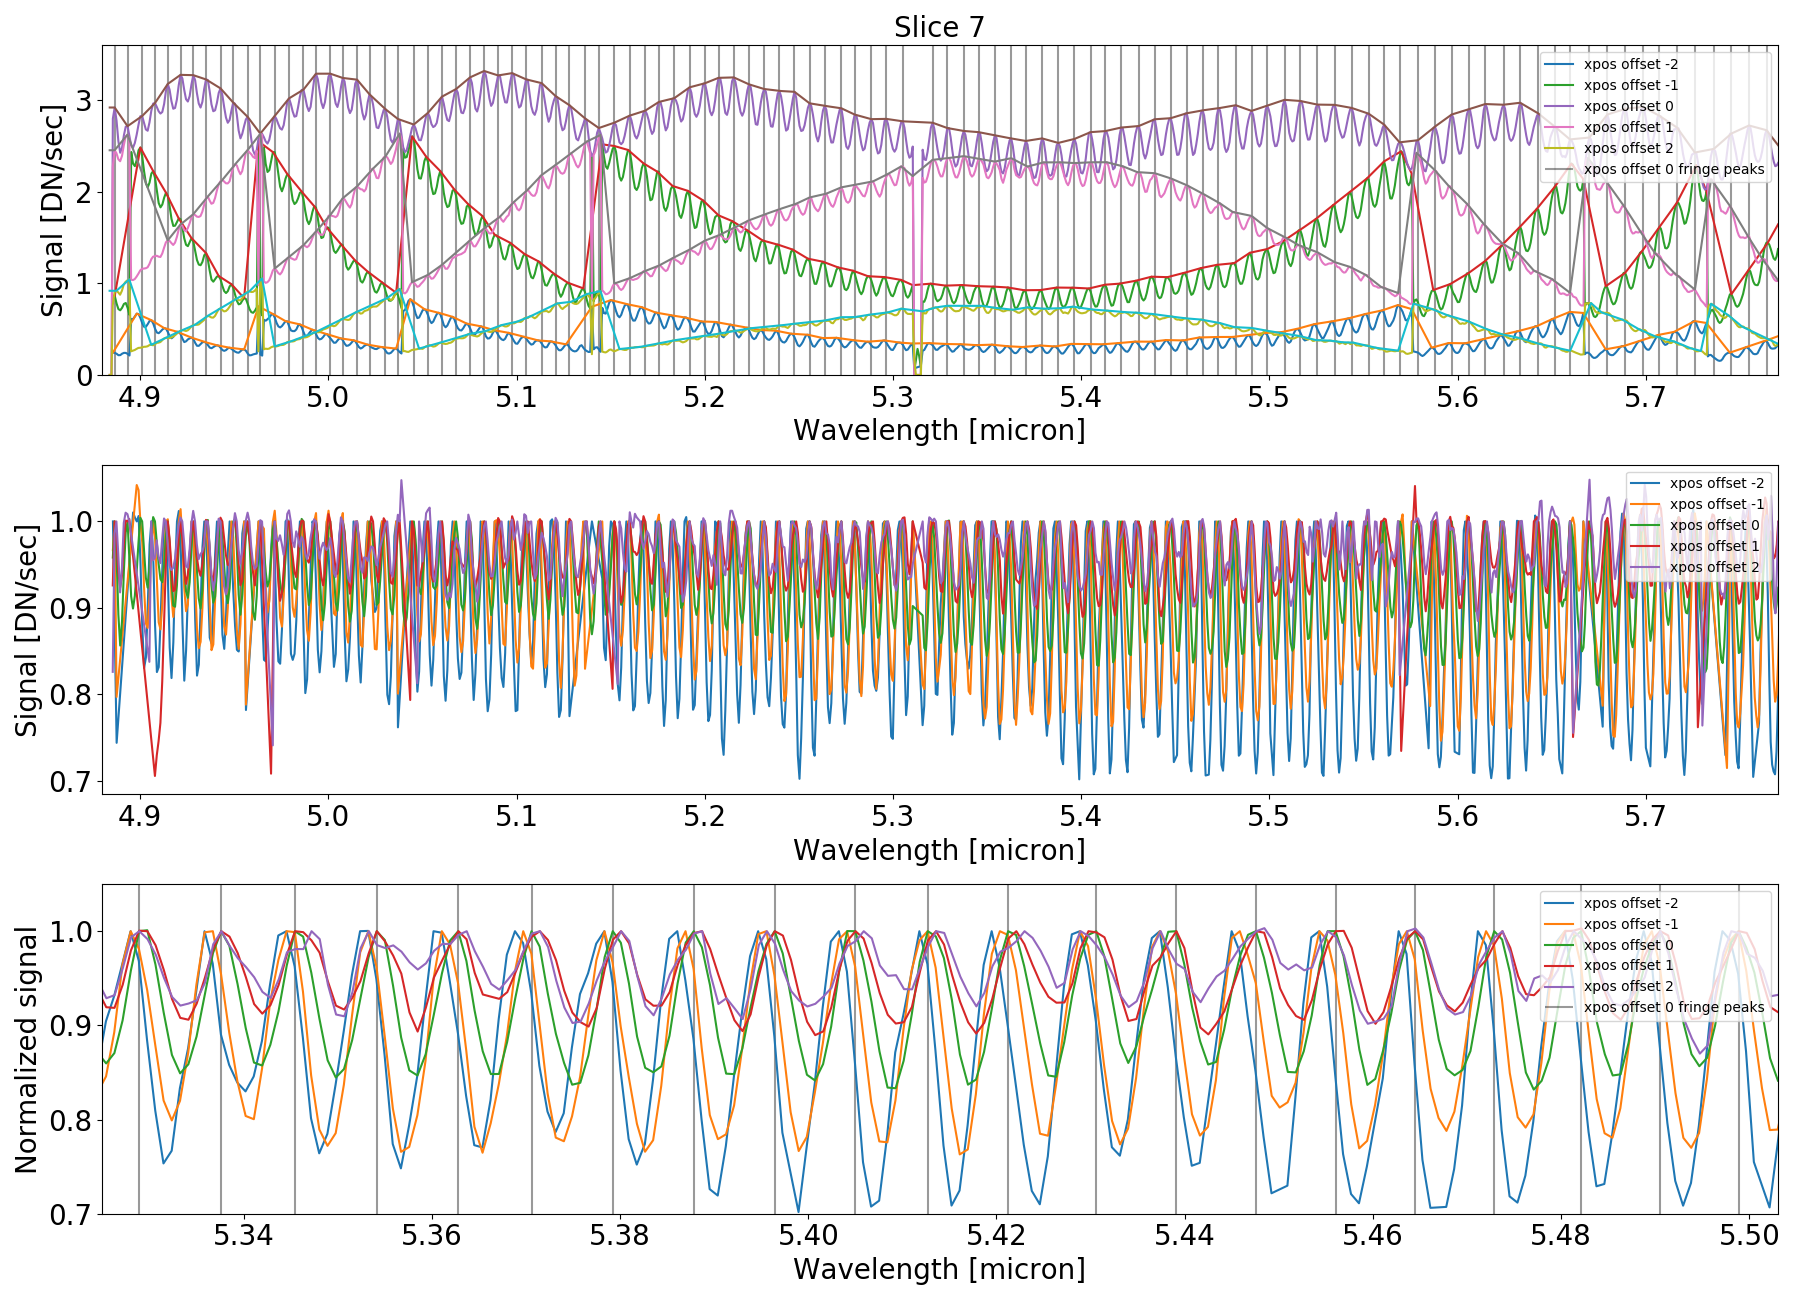

In [10]:
# let's look at the results (slice 6)
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Extended etalon data slice 7')
for xpos_offset in xpos_offsets:
    for plot in range(2):
        axs[plot].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],ext_etal_source_oddevencorr[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],label='xpos offset {}'.format(xpos_offset))
        axs[plot].set_xlabel('Wavelength [micron]')
        axs[plot].set_ylabel('Signal [DN/sec]')
        axs[plot].legend(loc='upper right',fontsize=10)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0)
axs[1].set_xlim(5.196,5.274)
axs[1].set_ylim(0)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Slice 7')
axs[0].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][pointsource_slice7_norm['offset0'][1]],0,3.6,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],pointsource_slice7_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset],pointsource_slice7_norm['offset'+str(xpos_offset)][2])
    norm_transmission = pointsource_slice7_norm['offset'+str(xpos_offset)][0]/pointsource_slice7_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].vlines(lambdaMap[ypos_sourcecenterslice,xpos_sourcecenterslice][pointsource_slice7_norm['offset0'][1]],0.7,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(0,3.6)
axs[2].set_xlim(5.325,5.503)
axs[2].set_ylim(0.7,1.05)
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_ylabel('Signal [DN/sec]')
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

<IPython.core.display.Javascript object>


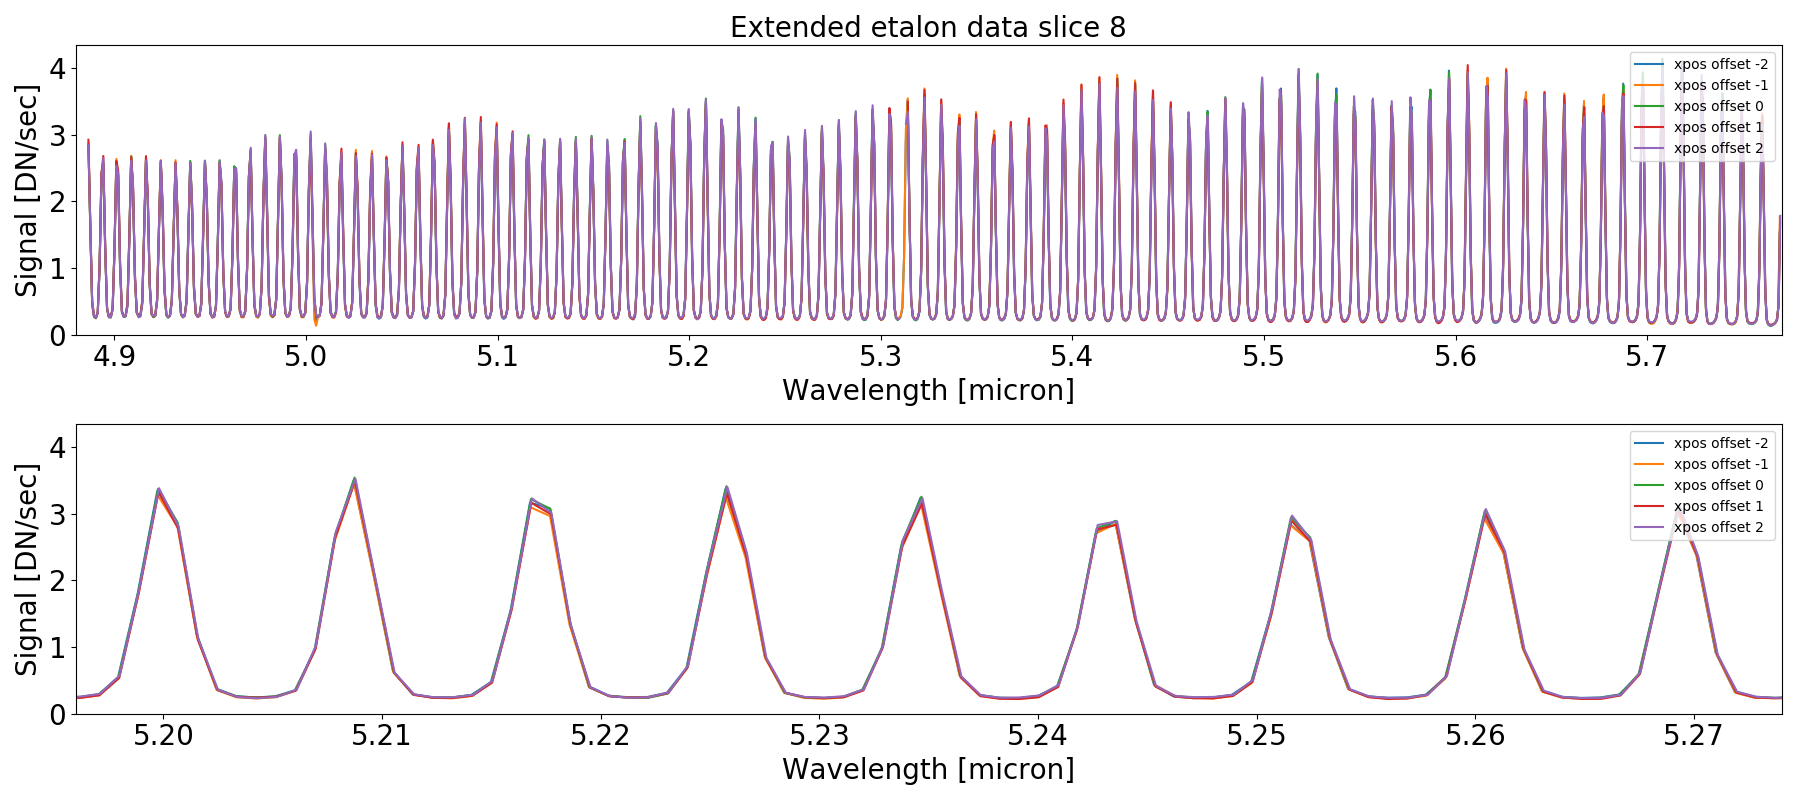

<IPython.core.display.Javascript object>


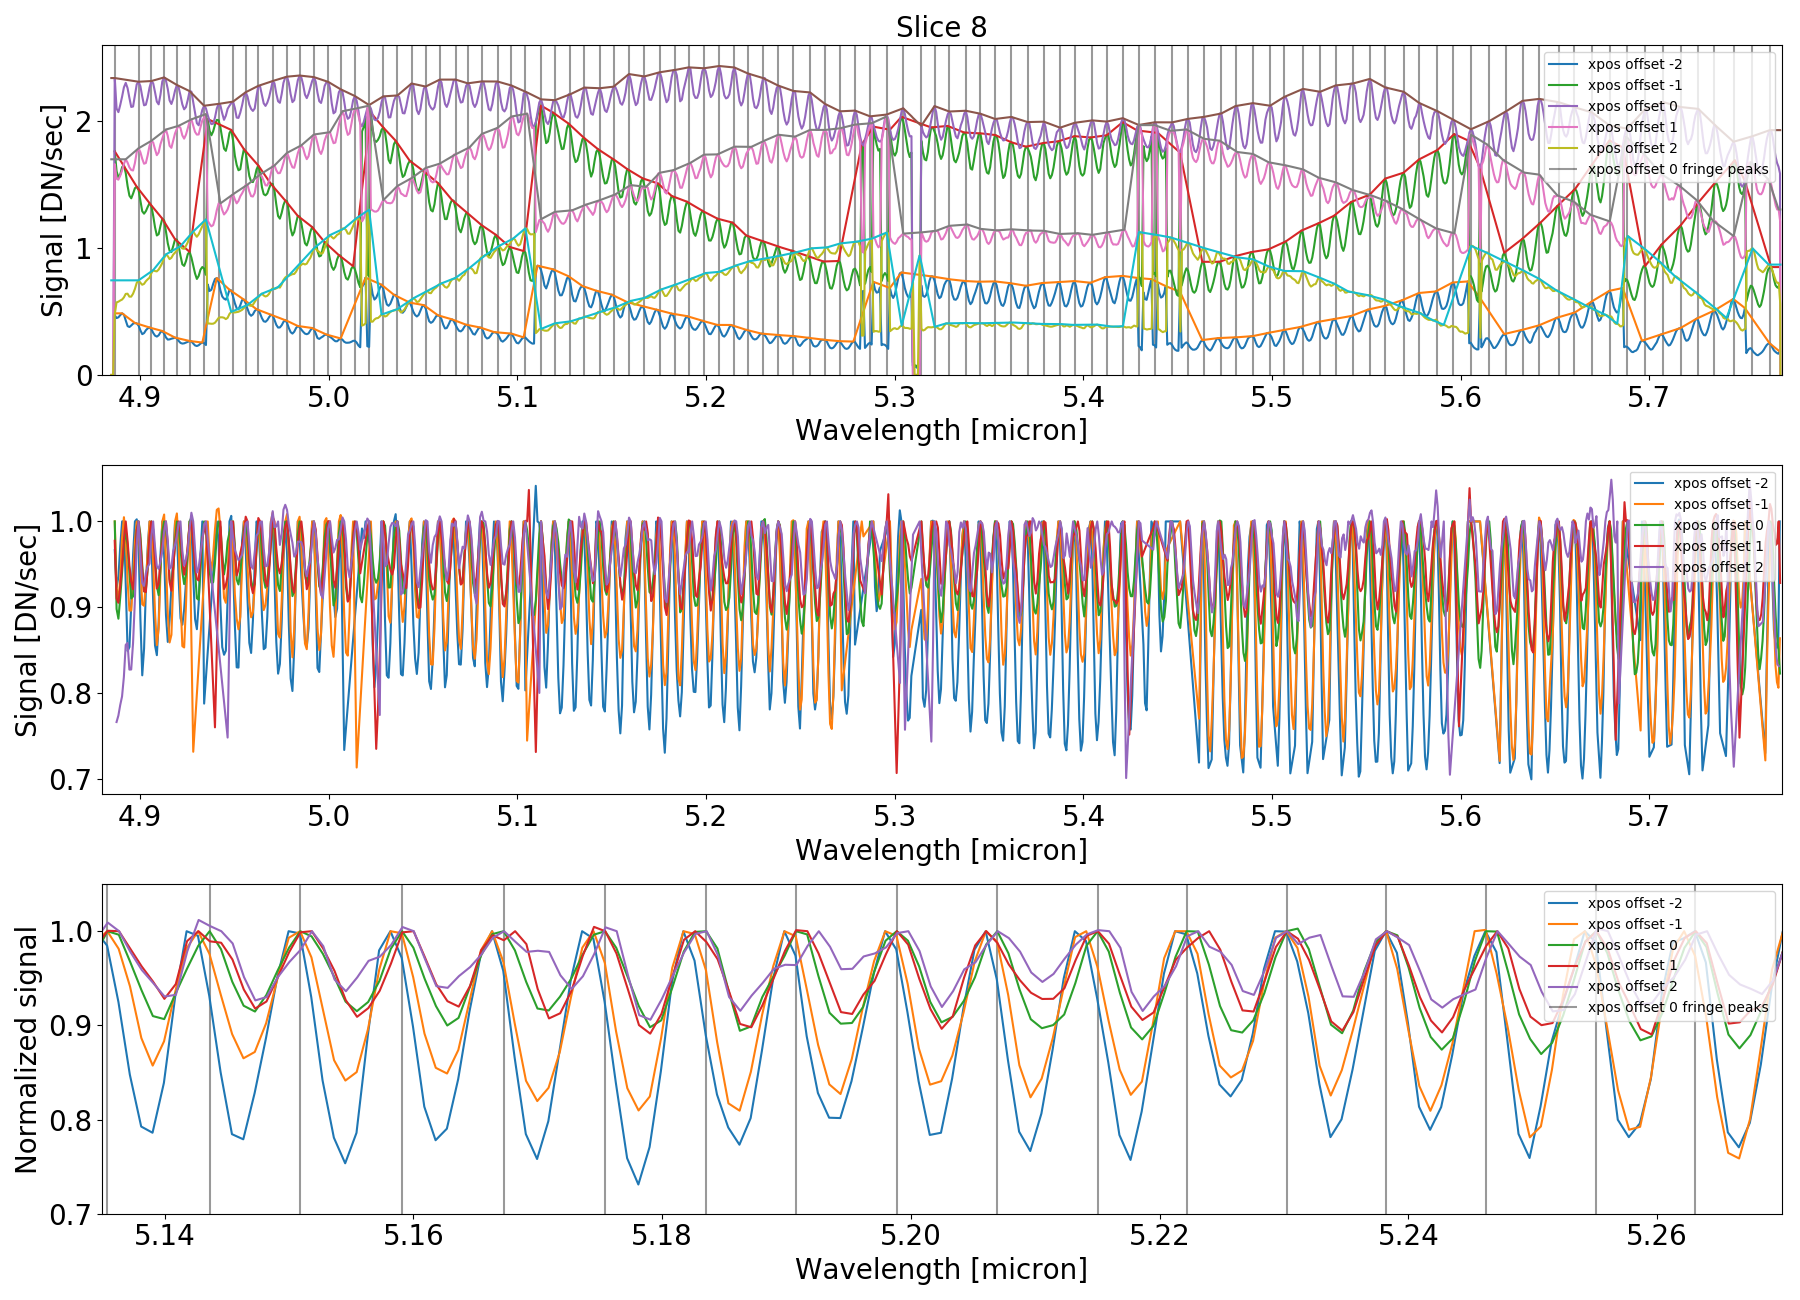

In [12]:
fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Extended etalon data slice 8')
for xpos_offset in xpos_offsets:
    for plot in range(2):
        axs[plot].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],ext_etal_source_oddevencorr[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],label='xpos offset {}'.format(xpos_offset))
        axs[plot].set_xlabel('Wavelength [micron]')
        axs[plot].set_ylabel('Signal [DN/sec]')
        axs[plot].legend(loc='upper right',fontsize=10)
axs[0].set_xlim(4.88,5.77)
axs[0].set_ylim(0)
axs[1].set_xlim(5.196,5.274)
axs[1].set_ylim(0)
plt.tight_layout()

fig,axs = plt.subplots(3,1,figsize=(18,13))
axs[0].set_title('Slice 8')
axs[0].vlines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2][pointsource_slice8_norm['offset0'][1]],0,2.6,alpha=0.4,label='xpos offset 0 fringe peaks')
for xpos_offset in xpos_offsets:
    axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],pointsource_slice8_norm['offset'+str(xpos_offset)][0],label='xpos offset {}'.format(xpos_offset))
    axs[0].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset],pointsource_slice8_norm['offset'+str(xpos_offset)][2])
    norm_transmission = pointsource_slice8_norm['offset'+str(xpos_offset)][0]/pointsource_slice8_norm['offset'+str(xpos_offset)][2]
    sel = (norm_transmission>0.7) & (norm_transmission<1.05)
    axs[1].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
    axs[2].plot(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2+xpos_offset][sel],norm_transmission[sel],label='xpos offset {}'.format(xpos_offset))
axs[2].vlines(lambdaMap[ypos_nearbyslice2,xpos_nearbyslice2][pointsource_slice8_norm['offset0'][1]],0.7,1.05,alpha=0.4,label='xpos offset 0 fringe peaks')
axs[0].set_ylim(0,2.6)
axs[2].set_xlim(5.135,5.27)
axs[2].set_ylim(0.7,1.05)
axs[2].set_ylabel('Normalized signal')
for plot in range(2):
    axs[plot].set_xlim(4.88,5.77)
    axs[plot].set_ylabel('Signal [DN/sec]')
for plot in range(3):
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].legend(loc='upper right',fontsize=10)
plt.tight_layout()

### Remarks:
* The same conclusions are drawn for slice 7 and slice 8, as per the remarks for slice 6. Similar to the discussion in Notebook 2, the change in fringe amplitude cannot be related to a real change in the reflectivity of the resonator, but a loss of capacity of the detectors to resolve the fringes produced by the detector. This "loss of capacity" seems to be related to the location on the PSF itself, and not based on the along-slice position, given the tests performed so far.
* The phase shift that we see here is much more important than the phase shift illustrated in Notebook 4 - Test 3, where we looked at the fringe behavior at the peak of the PSF for point sources located on the left and middle of the FOV. As such we cannot relate this to an "along-slice correction". Furthermore we have shown in Notebook 3 - Test 2 that the point source etalon lines (not the extended etalon lines) show no phase shift in different along-slice positions. This was shown in slice 9, 10, and 11, thus it is safe to assume that the fact holds in all slices. This brings us to think that the two datasets cannot be used complimentarily to solve the problem (but to assure that the wavelength calibration is satisfied in all positions). What is the fundamental difference between the point source etalon data fringes and the point source fringes though? The former is born from the etalon ("ET1A") while the latter is born from the MIRI detector. How do the detectors behave under different illumination patterns?

## Conclusions:  
* There is a variation of fringe phase with location on the PSF.
* The variation in across-slice direction (different slices) of the phase can conceivably be accounted for by a slight change in the detector optical properties.
* The variation in along-slice direction on the PSF does not match that of the point source etalon data seen in Notebook 3 - Test 2. It is clear that the detector behaves differently to an etalon.

## Follow-up question:  
Where do the extended source fringes "stand" with respect to the point source fringes? We know that the former do not shift in along-slice direction, but do the position of the fringe peaks match that of the point source fringes?